In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mticker

import numpy as np

import obspy
from obspy.clients.fdsn import Client as FDSN_Client
from obspy.geodetics import base
from obspy.taup import TauPyModel

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.io.shapereader as shpreader

In [2]:
# SISSLE locations and station pairs

auspass = FDSN_Client('http://auspass.edu.au:8080')
inv = auspass.get_stations(network="2B", level='response')

locations = {}
for station in inv[0]:
    if station.code in ['SIS01', 'SIS05']:
        continue
    locations[station.code] = (station.latitude, station.longitude)

station_pairs = []
for i, station in enumerate(inv[0]):
    if station.code in ['SIS01', 'SIS05']:
        continue
    for j in range(i+1, len(inv[0])):
        d = base.gps2dist_azimuth(inv[0][i].latitude, inv[0][i].longitude, 
                                  inv[0][j].latitude, inv[0][j].longitude)[0]
        if d <= 150:
            print('Distance between {} and {}: {:.4f} meters'.format(inv[0][i].code, inv[0][j].code, d))
            station_pairs.append((inv[0][i].code, inv[0][j].code))

Distance between SIS02 and SIS11: 97.9857 meters
Distance between SIS03 and SIS14: 68.2820 meters
Distance between SIS03 and SIS18: 99.7533 meters
Distance between SIS11 and SIS12: 115.2334 meters
Distance between SIS12 and SIS13: 94.2957 meters
Distance between SIS13 and SIS21: 106.6069 meters
Distance between SIS14 and SIS15: 119.8736 meters
Distance between SIS15 and SIS16: 103.3428 meters
Distance between SIS16 and SIS17: 128.1478 meters
Distance between SIS17 and SIS23: 101.7078 meters
Distance between SIS18 and SIS19: 98.3049 meters
Distance between SIS19 and SIS20: 109.1996 meters
Distance between SIS19 and SIS22: 128.0512 meters
Distance between SIS20 and SIS21: 145.5598 meters
Distance between SIS20 and SIS22: 73.4501 meters
Distance between SIS23 and SIS24: 101.6557 meters
Distance between SIS25 and SIS26: 105.3990 meters
Distance between SIS26 and SIS27: 93.2289 meters
Distance between SIS28 and SIS29: 109.4039 meters


In [3]:
# estimate cable center location
HAAST_lat = -43.906429
HAAST_lon = 169.064641

# Read array location
file_path = 'SISSLE_south_FINAL.csv'
DAS_array = np.genfromtxt(file_path, delimiter=',', names=True, dtype=[('channel', 'i8'), ('status', 'U10'), ('latitude', 'f8'), ('longitude', 'f8'), ('elevation', 'f8')], encoding=None)

DAS_array_lat = []; DAS_array_lon = []; DAS_channel_list = []
for item in DAS_array:
    if item[1] == 'good':
        DAS_array_lat.append(item[2])
        DAS_array_lon.append(item[3])
        DAS_channel_list.append(item[0])

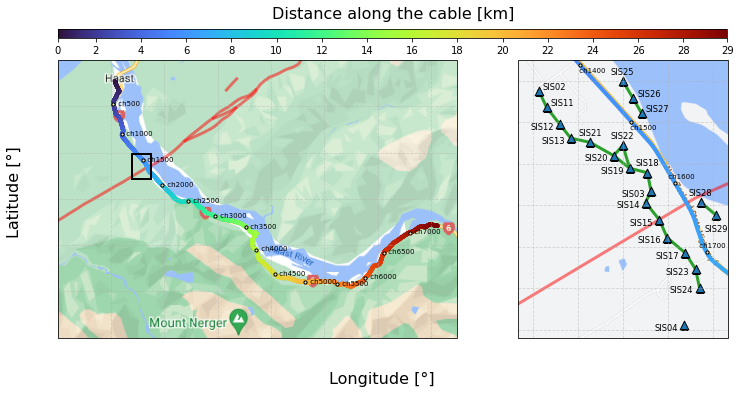

In [4]:
shp = shpreader.Reader('NZAFD_250K_Oct_2023_WGS84.shp')

fonts = 16
scale_bar_kwargs = {'location':(0.9,0.92)} 
map_tiles = cimgt.GoogleTiles(style="street")

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.91, 1])
axs = [fig.add_subplot(gs[0], projection=map_tiles.crs), fig.add_subplot(gs[1],projection=map_tiles.crs)]

# left plot

map_tiles = cimgt.GoogleTiles(style="street")

extent1 = (169.00,169.30,-44.00,-43.85)
axs[0].set_extent(extent1)
axs[0].add_image(map_tiles, 11)
gl = axs[0].gridlines(draw_labels=True, alpha=0.5, linestyle='--')
gl.top_labels = None;  
gl.right_labels = None;
gl.xlabel_style = {'size': 7} 
gl.ylabel_style = {'size': 7} 
gl.xlocator = mticker.MaxNLocator(nbins=9)
gl.ylocator = mticker.MaxNLocator(nbins=7)
gl.xformatter = mticker.FuncFormatter(lambda x, _: f'{x:.2f}')
gl.yformatter = mticker.FuncFormatter(lambda y, _: f'{y:.2f}')

# DAS array
x, y, _ = map_tiles.crs.transform_points(ccrs.Geodetic(), np.array(DAS_array_lon), np.array(DAS_array_lat)).T
scatter = axs[0].scatter(x, y, s=10, c=DAS_channel_list, cmap='turbo', marker="o", edgecolor=None, zorder=2, alpha=0.5)

# right plot position
extent2 = (169.056,169.07,-43.9144,-43.901)
x, y, _ = map_tiles.crs.transform_points(ccrs.Geodetic(), np.array([extent2[0], extent2[1]]), np.array([extent2[2], extent2[3]])).T
height = y[1] - y[0]
width = x[1] - x[0]
axs[0].add_patch(Rectangle((x[0], y[0]), width, height, linewidth=2, edgecolor="k", facecolor='none', zorder=3))

# lower left plot
# ax_inset = inset_axes(axs[0], width="40%", height="40%", loc='lower left', borderpad=-1)
# left plot position
# x, y, _ = map_tiles.crs.transform_points(ccrs.Geodetic(), np.array([extent1[0], extent1[1]]), np.array([extent1[2], extent1[3]])).T
# height = y[1] - y[0]
# width = x[1] - x[0]
# ax_inset.add_patch(Rectangle((x[0], y[0]), width, height, linewidth=3, edgecolor="k", facecolor='none', zorder=3))

# right plot

map_tiles = cimgt.GoogleTiles(style="street")

axs[1].set_extent(extent2)
axs[1].add_image(map_tiles, 15)
gl = axs[1].gridlines(draw_labels=True, alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None
gl.xlabel_style = {'size': 7} 
gl.ylabel_style = {'size': 7}
gl.xlocator = mticker.MaxNLocator(nbins=5)
gl.ylocator = mticker.MaxNLocator(nbins=7)
gl.xformatter = mticker.FuncFormatter(lambda x, _: f'{x:.3f}')  
gl.yformatter = mticker.FuncFormatter(lambda y, _: f'{y:.3f}')

for pair in station_pairs:
    st1, st2 = pair
    x, y, _ = map_tiles.crs.transform_points(ccrs.Geodetic(), np.array([locations[st1][1], locations[st2][1]]), np.array([locations[st1][0], locations[st2][0]])).T

    axs[1].plot(x, y, linestyle='-', lw=3, label=pair, zorder=1, color='tab:green')

x, y, _ = map_tiles.crs.transform_points(ccrs.Geodetic(), np.array([l[1] for l in locations.values()]), np.array([l[0] for l in locations.values()])).T
axs[1].scatter(x, y, s=75, marker='^', color='tab:blue', edgecolors='k', linewidths=1, zorder=2)

fs = 'small'
# left
for i in [1,2,4,5,6,7,8,9,11,12,15,16]:
    axs[1].text(x[i]-220, y[i]-40, list(locations.keys())[i], fontsize=fs)
# right
for i in [0,3,18,19]:
    axs[1].text(x[i]+30, y[i]+10, list(locations.keys())[i], fontsize=fs)
# top
for i in [10,13,14,17,20]:
    axs[1].text(x[i]-90, y[i]+50, list(locations.keys())[i], fontsize=fs)
# bottom
for i in [21]:
    axs[1].text(x[i]-90, y[i]-120, list(locations.keys())[i], fontsize=fs)


x, y, _ = map_tiles.crs.transform_points(ccrs.Geodetic(), np.array(DAS_array_lon), np.array(DAS_array_lat)).T
scatter = axs[1].scatter(x, y, s=10, c=DAS_channel_list, cmap='turbo', marker="o", edgecolor=None, zorder=2, alpha=0.5)

cols = np.linspace(81,7488,len(x))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='turbo')
lc.set_array(cols)
lc.set_linewidth(1)
line = axs[1].add_collection(lc)

cb = fig.colorbar(line, ax=axs, location='top', shrink=1, aspect=70, pad=0.05, ticks=[81,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7488],
                  format = FuncFormatter(lambda x, pos: f'{int((x * 0.001 * 4))}'))
cb.ax.xaxis.set_ticks_position("bottom")
cb.set_label(label='Distance along the cable [km]', labelpad=10, size=fonts)

# Add Alpine Fault shapefile to both plots
for record in shp.records():
    geometry = record.geometry
    axs[0].add_geometries([geometry], ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=3, alpha=0.5)
    axs[1].add_geometries([geometry], ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=3, alpha=0.5)

# Add text for scatter points at specific intervals
for i,ch in enumerate(DAS_channel_list):
    if ch % 500 == 0:
        axs[0].scatter(x[i], y[i], s=10, c='#EAE2B7', marker="o", edgecolor='black', zorder=4)
        axs[0].text(x[i]+200, y[i]+300, ' ch'+f'{ch:.0f}', fontsize=7, ha='left', va='top', c='black')
    if ch == 1400 or ch == 1500:
        axs[1].scatter(x[i], y[i], s=10, c='#EAE2B7', marker="o", edgecolor='black', zorder=4)
        axs[1].text(x[i]-20, y[i]-20, ' ch'+f'{ch:.0f}', fontsize=7, ha='left', va='top', c='black')
    if ch == 1600 or ch == 1700:
        axs[1].scatter(x[i], y[i], s=10, c='#EAE2B7', marker="o", edgecolor='black', zorder=4)
        axs[1].text(x[i]-70, y[i]+70, ' ch'+f'{ch:.0f}', fontsize=7, ha='left', va='top', c='black')
        

fig.text(0.5, 0.175, 'Longitude [°]', ha='center', va='center', fontsize=fonts)
fig.text(0.075, 0.5, 'Latitude [°]', ha='center', va='center', rotation='vertical', fontsize=fonts)

plt.savefig('./out/figure_01.pdf', bbox_inches='tight')
plt.show()